## Run_QLC_FT

This code solves the QLC problem in Fourier space. Parameters include:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time

Iwantrfft = True; Iwantfft = not Iwantrfft
if Iwantrfft:
    from scipy.fft import rfft, irfft, rfftfreq
    my_fft = rfft
    my_ifft = irfft
    my_fftfreq = rfftfreq
else:
    from scipy.fft import fft, ifft, fftfreq
    my_fft = fft
    my_ifft = ifft
    my_fftfreq = fftfreq

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

### Getting parameters for this run

In [3]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [4]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [5]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Runtime parameters from the namelist 

In [6]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 50 millisecond
This is a run from time 0.0 millisecond to 50.0 millisecond
dt = 1020.4081632653061 microsecond


### Run the scenario in Cartesian space

10 % elapsed time is 0.007 minutes
20 % elapsed time is 0.012 minutes
30 % elapsed time is 0.017 minutes
40 % elapsed time is 0.022 minutes
50 % elapsed time is 0.027 minutes
60 % elapsed time is 0.032 minutes
70 % elapsed time is 0.037 minutes
80 % elapsed time is 0.042 minutes
90 % elapsed time is 0.047 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


<IPython.core.display.Javascript object>


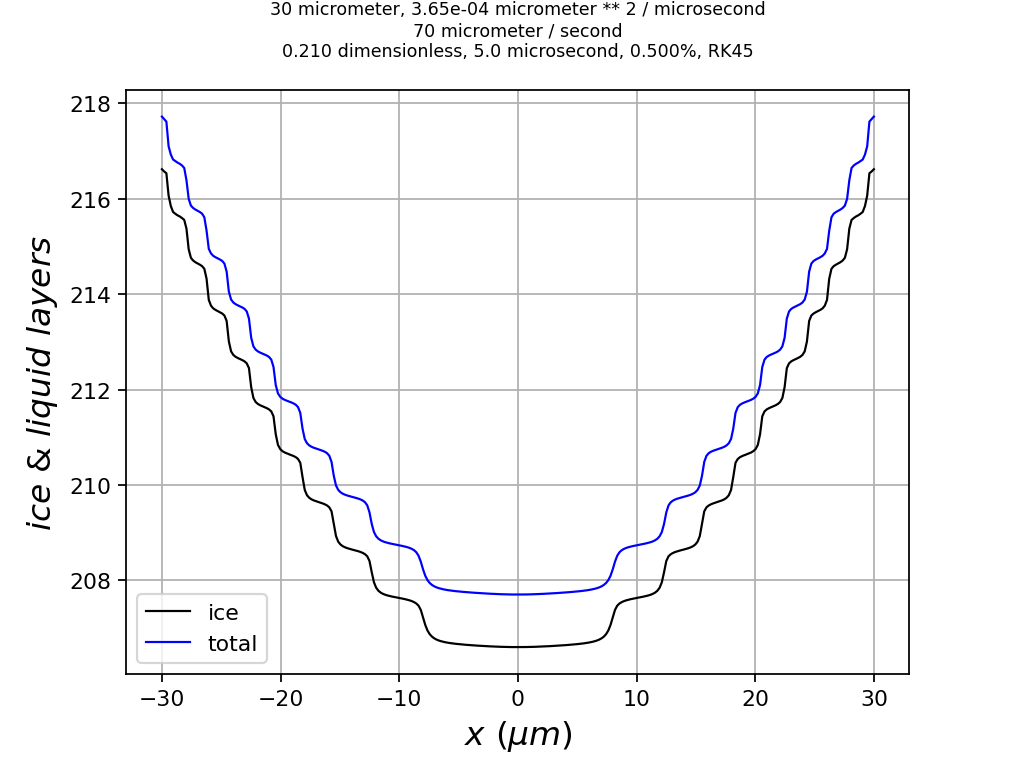

<IPython.core.display.Javascript object>


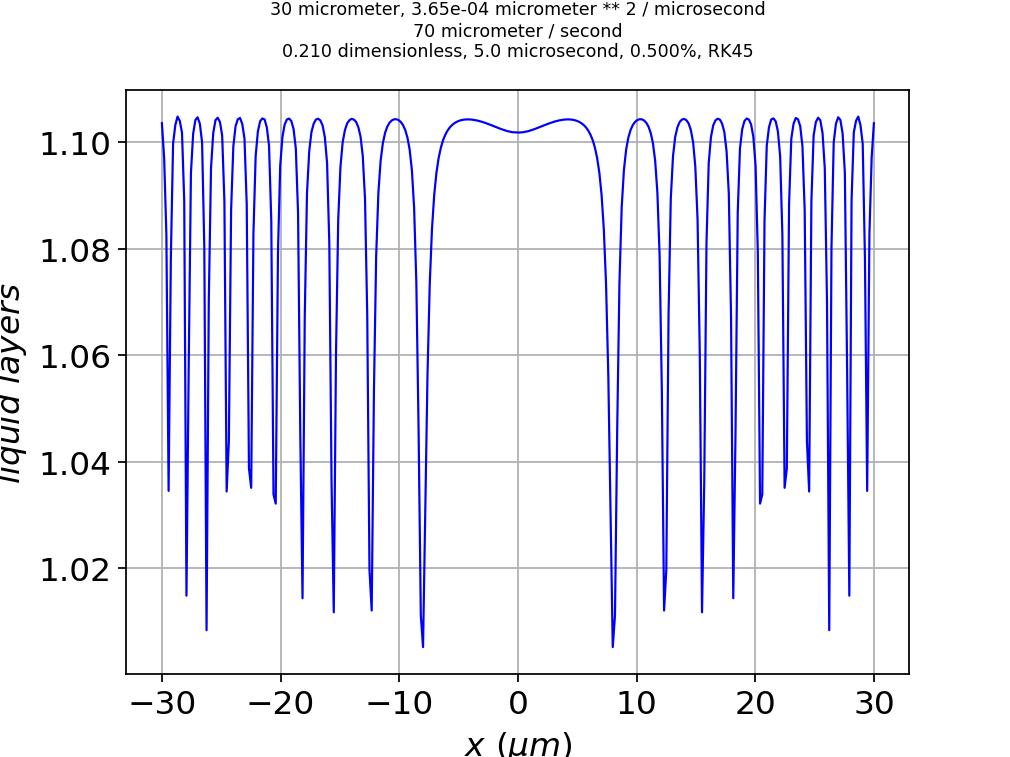

<IPython.core.display.Javascript object>


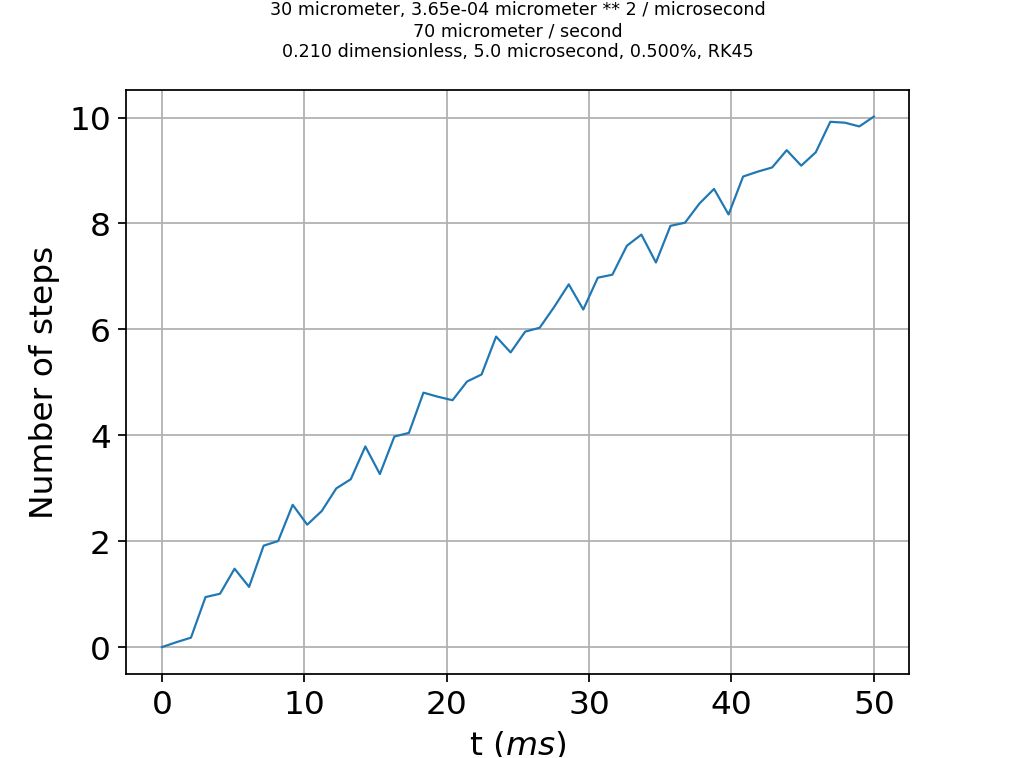

In [7]:
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Reporting and graphing
# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.to('percent').magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

In [8]:
# This is a local copy of run_f1d_FT and f1d_solve_ivp_FT (for exploring FT)
def run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,times,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI,\
           AssignQuantity,\
           verbose=0, odemethod='RK45'):

    """ Solves the QLC problem, with units, in Fourier space """

    # Prep for the integration
    nt = len(times)
    lastprogress = 0
    sigmaI_mag = sigmaI.magnitude
    SigmaI_mag = my_fft(sigmaI_mag)
    t1 = time()
    
    # This is to get j2_list because it's more efficient to pre-calculate it (but we'll use bj_list later too)
    bj_list = my_fft(NQLL_init_1D)
    n_list = len(bj_list); print('n_list',n_list)
    
    if (str(my_fft).find("'rfft'")) > 0:
        print('this is an rfft calculation ...')
        n_list = len(bj_list); print('n_list',n_list)
        j_list = np.array([j for j in range(n_list)])
        
        # Make the j^2 list
        j2_list = np.array(j_list)**2
        
    elif (str(my_fft).find("'fft'")) > 0:
        print('this is an fft calculation ...')
        n_j_list = int(n_list/2); print('n_j_list',n_j_list)
        j_list_left = np.array([j for j in range(n_j_list+1)]); #print('length of j_list_left',len(j_list_left))
        
        # Make the j^2 list
        j_list_right = np.flip(j_list_left[1:-1])
        j_list = np.append(j_list_left,j_list_right); print('length of j_list', len(j_list))
        j2_list = j_list**2
        
    else:
        print('Oops, unrecognized fft')
        sys.exit()

    # Bundle parameters for ODE solver
    scalar_params = np.array([\
       Nbar, Nstar, sigma0.magnitude, nu_kin_mlyperus.magnitude, DoverL2pi2.magnitude, tau_eq.magnitude])

    # Package up the dynamical variables as FT 
    aj_list = my_fft(Ntot_init_1D)
    Ylast = np.array([bj_list,aj_list])
    Ylast = np.reshape(Ylast,2*n_list)
    Ykeep_1D = [Ylast]
        
    # Loop over times
    for i in range(0,nt-1):
                
        # Specify the time interval of this step
        tinterval = [times[i].magnitude,times[i+1].magnitude]
        
        # Integrate up to next time step
        sol = solve_ivp(\
            f1d_solve_ivp_FT, tinterval, Ylast, args=(scalar_params, SigmaI_mag, j2_list), \
            rtol=1e-12, method=odemethod) 
        Ylast = sol.y[:,-1]
        
#       Symmetrizing in position space
        Ylast = np.array(Ylast, dtype=np.complex_)
        Ylast_reshaped = np.reshape(Ylast,(2,n_list))
        bj_list = Ylast_reshaped[0,:]
        aj_list = Ylast_reshaped[1,:]
        NQLL_last = my_ifft(bj_list)
        Ntot_last = my_ifft(aj_list)
        nx = len(NQLL_last)
        nx_mid = int(nx/2)
        for j in range(0,nx_mid):
            jp = nx -j -1
            Ntot_last[j] = Ntot_last[jp]
            NQLL_last[j] = NQLL_last[jp]
        bj_list = my_fft(NQLL_last)
        aj_list = my_fft(Ntot_last)
        Ylast = np.array([bj_list,aj_list])
        Ylast = np.reshape(Ylast,2*n_list)

        # Stuff into keeper arrays
        Ykeep_1D.append(Ylast)
        
        # Progress reporting
        progress = int(i/nt*100)
        if np.mod(progress,10) == 0:
            if progress > lastprogress:
                t2 = time()
                elapsed = (t2 - t1)/60
                print(progress,'%'+' elapsed time is %.3f minutes' %elapsed)
                lastprogress = progress

    print('100% done')
    print('status = ', sol.status)
    print('message = ', sol.message)
    print(dir(sol))
    
    # Packaging up the dynamical variables over time
    Ykeep_1Darr = np.array(Ykeep_1D, dtype=np.complex_)
    Ykeep_1Darr_reshaped = np.reshape(Ykeep_1Darr,(nt,2,n_list))
    Ykeep_NQLL_1D = Ykeep_1Darr_reshaped[:,0,:]
    Ykeep_Ntot_1D = Ykeep_1Darr_reshaped[:,1,:]
    
    # Convert to Cartesian values
    Ntotkeep_1D = my_ifft(Ykeep_Ntot_1D)
    NQLLkeep_1D = my_ifft(Ykeep_NQLL_1D)
    
    # Return the Cartesian values    
    return Ntotkeep_1D, NQLLkeep_1D

def f1d_solve_ivp_FT(t, Y, scalar_params, SigmaI, j2_list):

    # Unpack parameters
    Nbar, Nstar, sigma0, nu_kin_mlyperus, Dcoefficient1, tau_eq = scalar_params
    l = int(len(Y)/2)

    # Extract the dynamical variables
    bj_list = Y[:l]
    aj_list = Y[l:]
    
    # Convert some variables to position space
    NQLL0 = my_ifft(bj_list)
    Ntot0 = my_ifft(aj_list)
    nx_crystal = len(Ntot0)

    # Start with the diffusion term for Ntot
    cj_list = bj_list*j2_list
    daj_list_dt = -Dcoefficient1 * cj_list
    
    # Calculating the deposition term (works for rfft/irfft and fft/ifft)
    M = bj_list/(2*Nstar)
    M[0] -= (Nbar - Nstar)/(2*Nstar)*nx_crystal  
    Sigma_m = (SigmaI - M * sigma0)
    Deposition_term = nu_kin_mlyperus * Sigma_m

    # Add in the deposition term
    daj_list_dt += Deposition_term

    # Freezing/melting for NQLL (awkwardly done by reverse/forward FT -- but we may be stuck with this)
    deltaNQLL = QLC.getDeltaNQLL(Ntot0,Nstar,Nbar,NQLL0)
    DeltaNQLL = my_fft(deltaNQLL)
    dbj_list_dt = daj_list_dt - DeltaNQLL/tau_eq
    
    # Package up and return
    return np.concatenate((dbj_list_dt, daj_list_dt))

### Run the scenario in FT space for comparison

In [9]:
DoverL2pi2 = D/L**2*np.pi**2
Ntotkeep_1D_FT, NQLLkeep_1D_FT = run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

n_list 161
this is an rfft calculation ...
n_list 161
10 % elapsed time is 0.011 minutes
20 % elapsed time is 0.022 minutes
30 % elapsed time is 0.032 minutes
40 % elapsed time is 0.042 minutes
50 % elapsed time is 0.053 minutes
60 % elapsed time is 0.064 minutes
70 % elapsed time is 0.075 minutes
80 % elapsed time is 0.085 minutes
90 % elapsed time is 0.096 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


<IPython.core.display.Javascript object>


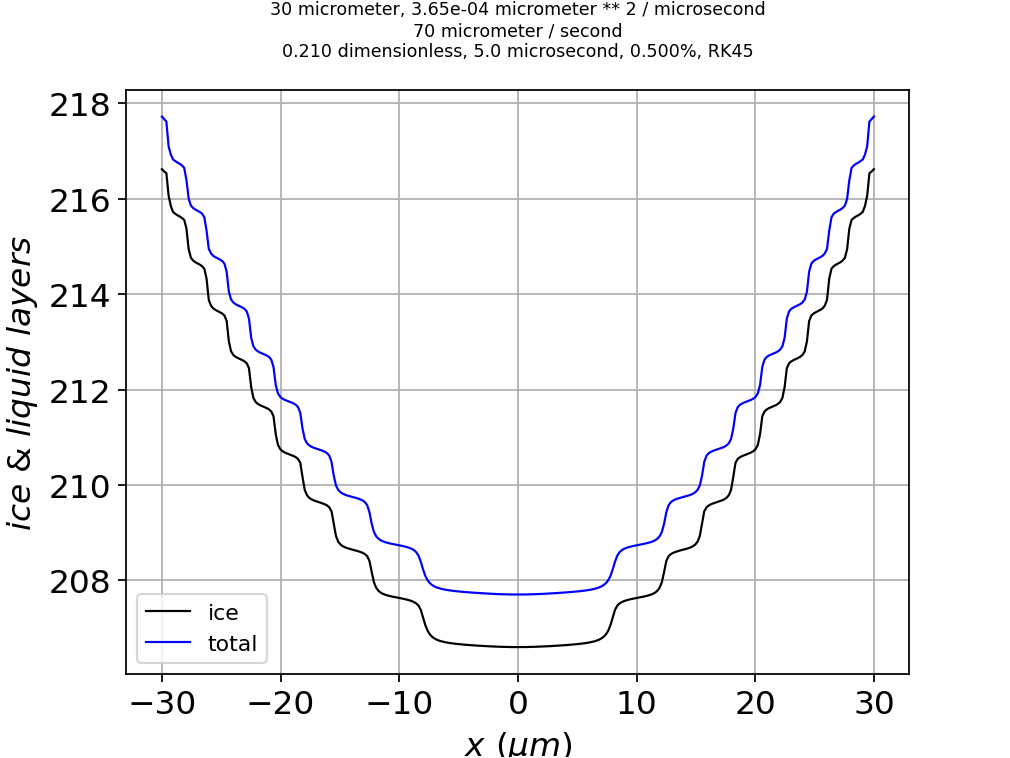

<IPython.core.display.Javascript object>


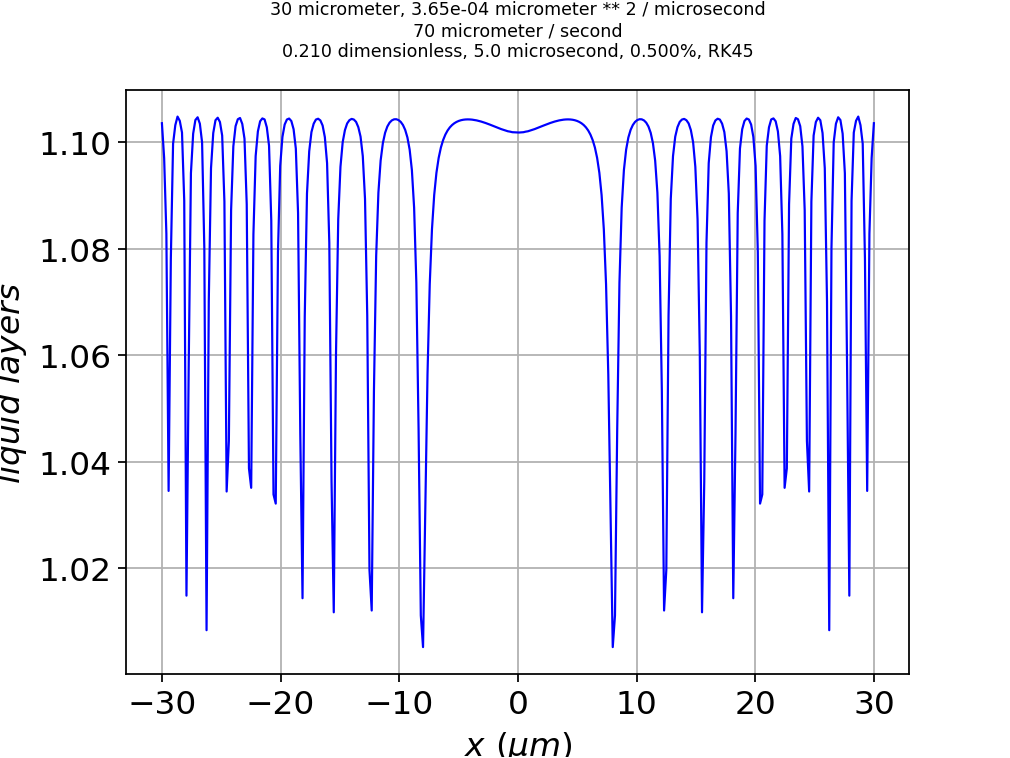

<IPython.core.display.Javascript object>


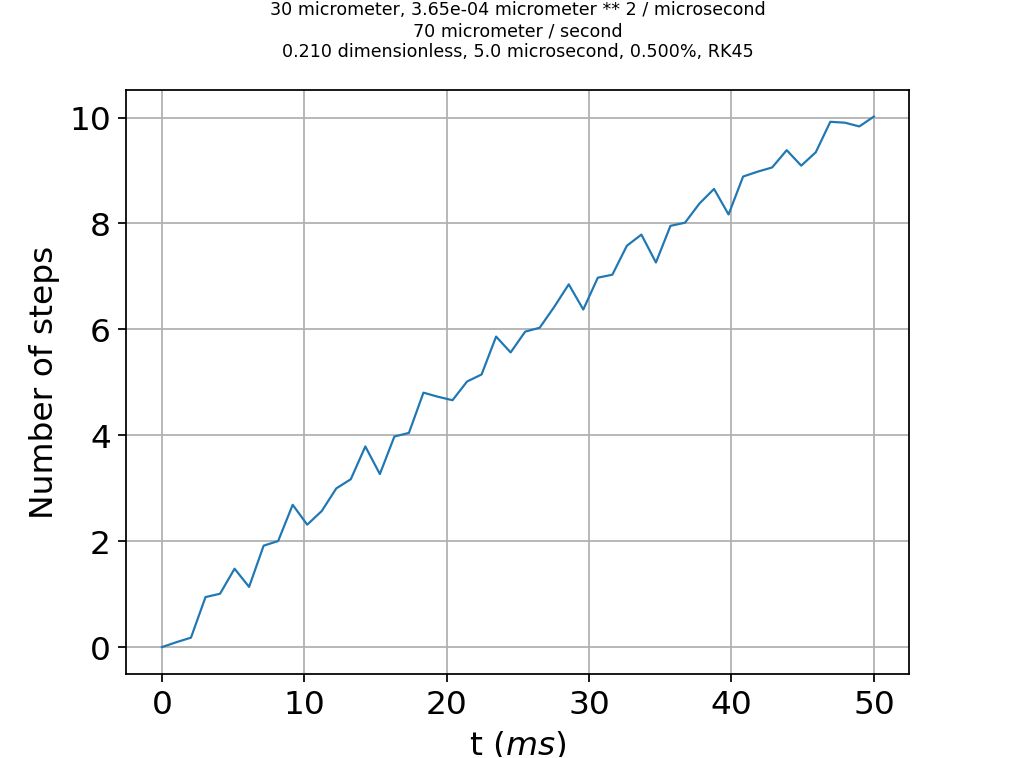

<IPython.core.display.Javascript object>


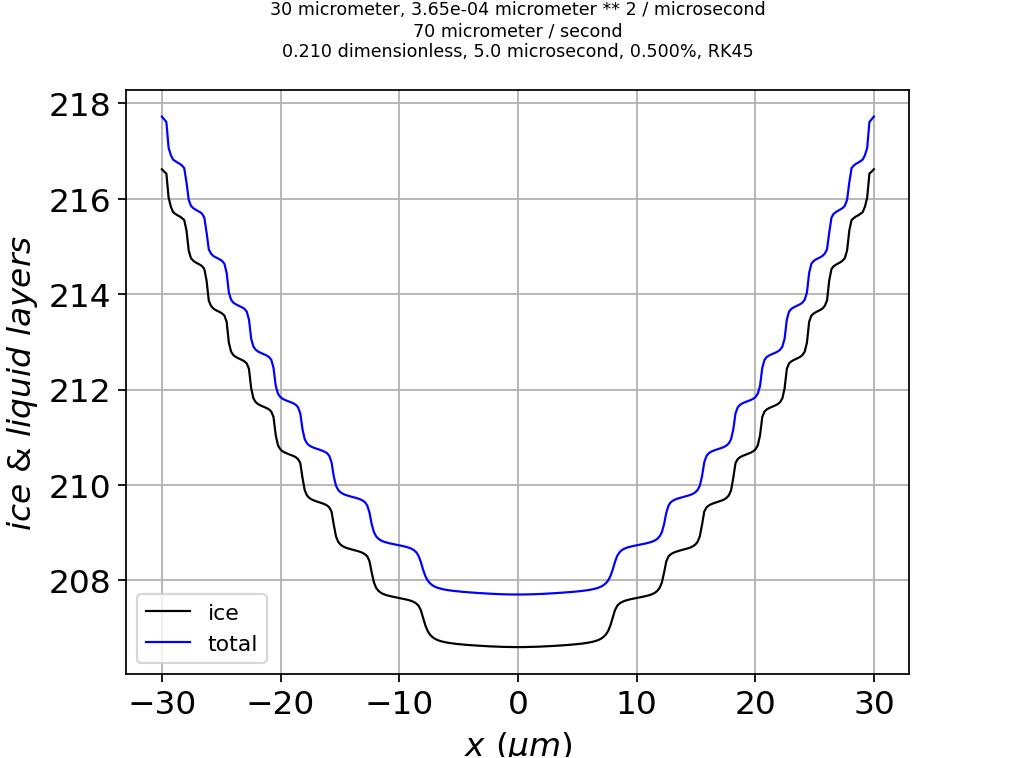

<IPython.core.display.Javascript object>


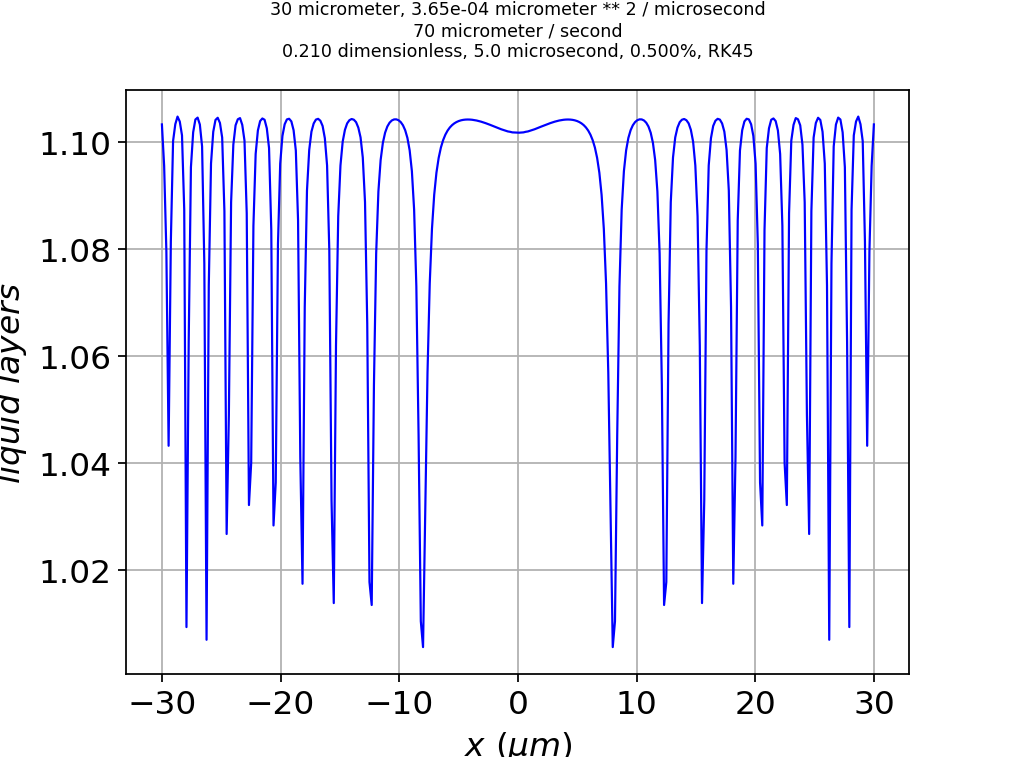

<IPython.core.display.Javascript object>


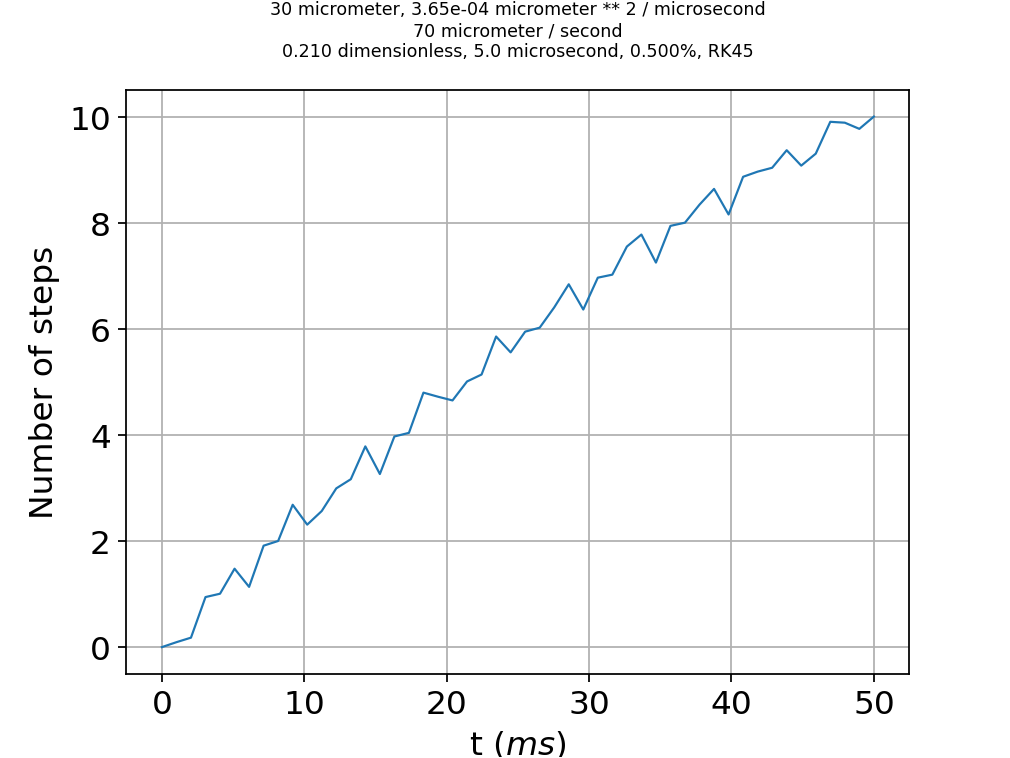

<IPython.core.display.Javascript object>


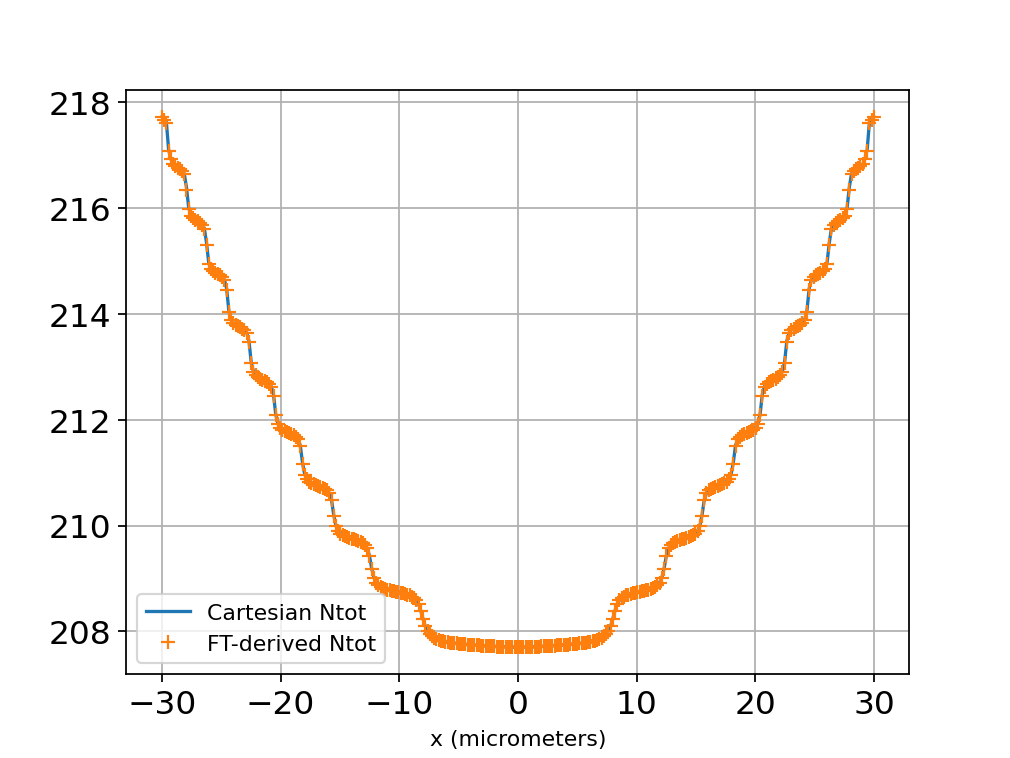

<IPython.core.display.Javascript object>


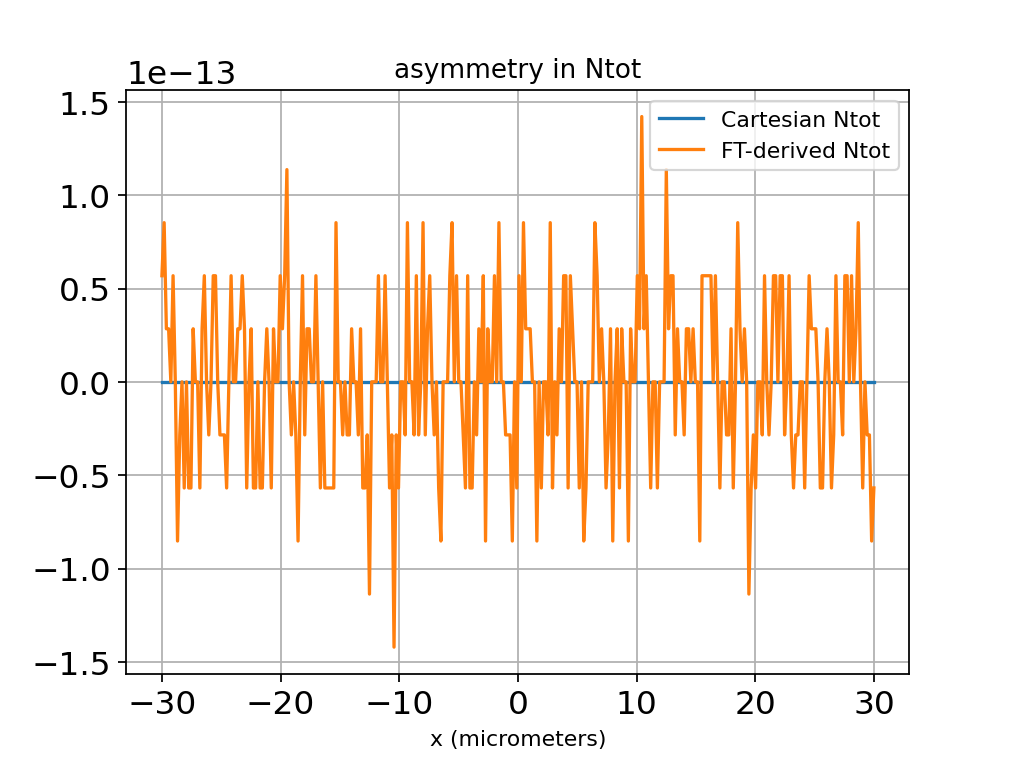

<IPython.core.display.Javascript object>


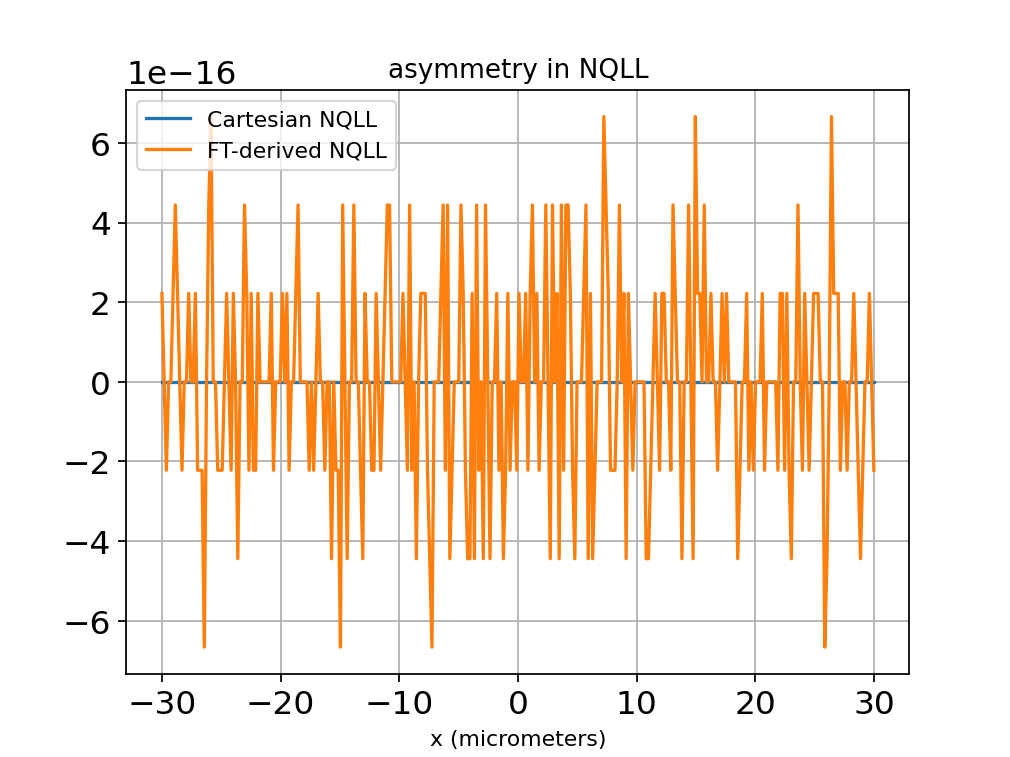

<IPython.core.display.Javascript object>


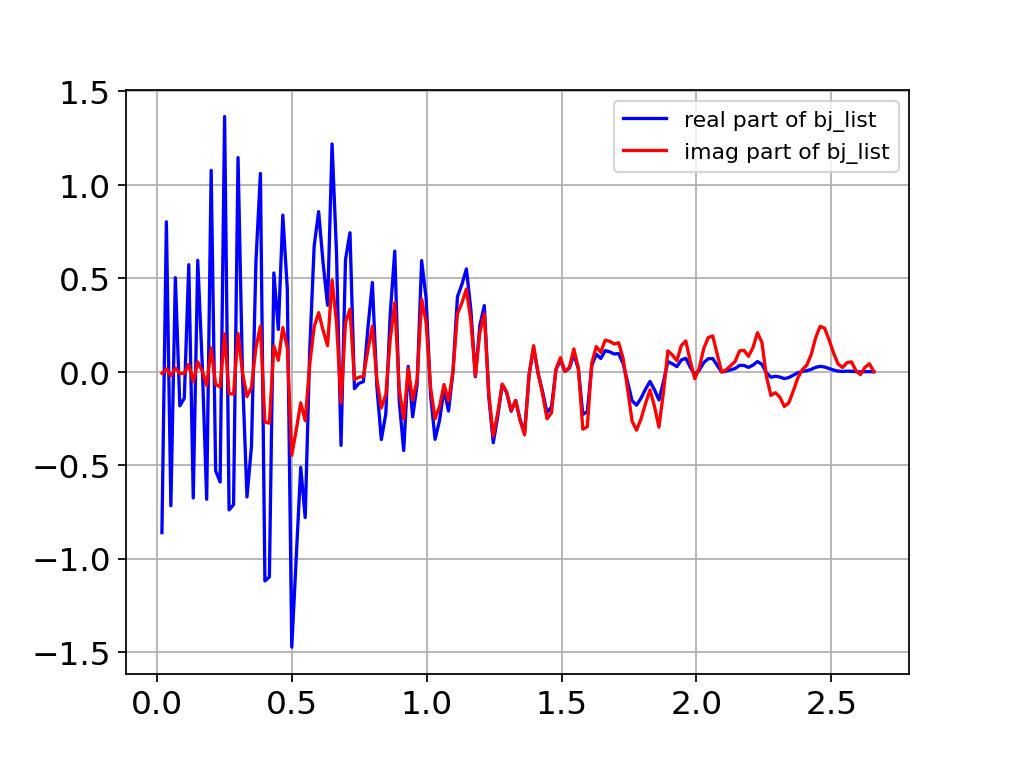

<IPython.core.display.Javascript object>


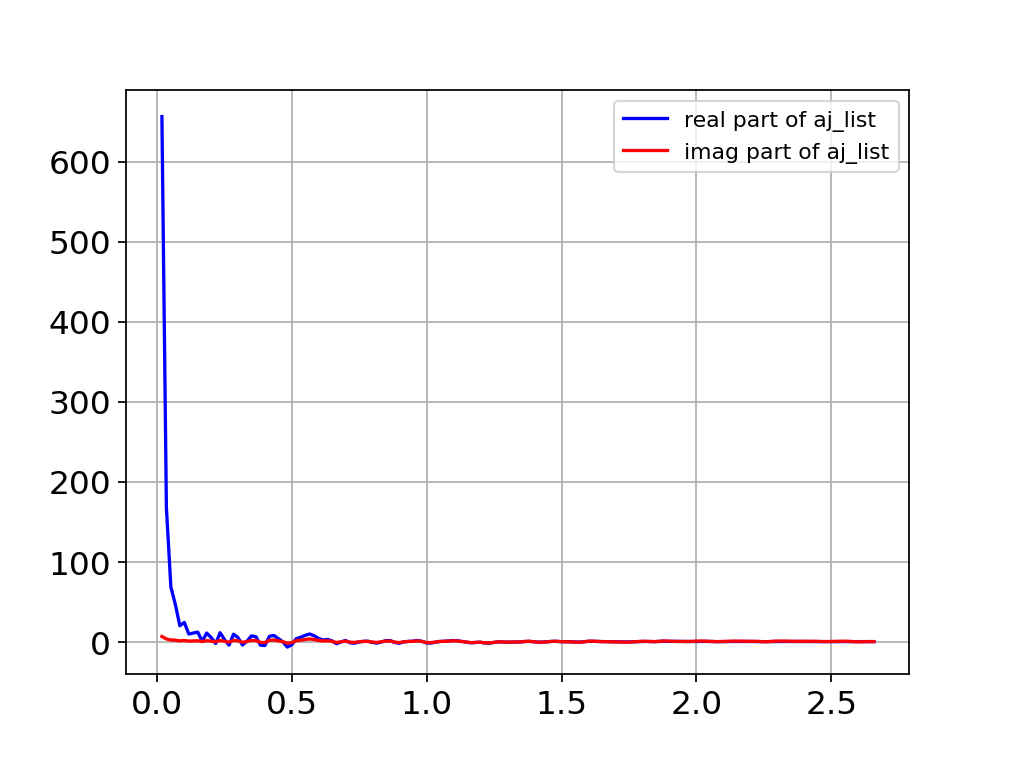

In [10]:
# Reporting
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_FT,Ntotkeep_1D_FT,Nicekeep_1D_FT,h_pr, \
        graphics=True,title_params=title_params)

whichone = -1
plt.figure()
plt.plot(x_QLC.magnitude,Ntotkeep_1D[-1],label='Cartesian Ntot')
plt.plot(x_QLC.magnitude,Ntotkeep_1D_FT[-1],'+',label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()

Ntot_difference_orig = Ntotkeep_1D[whichone]-np.flip(Ntotkeep_1D[whichone])
Ntot_difference_FT = Ntotkeep_1D_FT[whichone]-np.flip(Ntotkeep_1D_FT[whichone])
plt.figure()
plt.plot(x_QLC.magnitude,Ntot_difference_orig,label='Cartesian Ntot')
plt.plot(x_QLC.magnitude,Ntot_difference_FT,label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()
plt.title('asymmetry in Ntot')

NQLL_difference_orig = NQLLkeep_1D[-1]-np.flip(NQLLkeep_1D[whichone])
NQLL_difference_FT = NQLLkeep_1D_FT[-1]-np.flip(NQLLkeep_1D_FT[whichone])
plt.figure()
plt.plot(x_QLC.magnitude,NQLL_difference_orig,label='Cartesian NQLL')
plt.plot(x_QLC.magnitude,NQLL_difference_FT,label='FT-derived NQLL')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()
plt.title('asymmetry in NQLL')

kvalues = my_fftfreq(nx_crystal,deltax)
bj_list = my_fft(NQLLkeep_1D_FT[whichone])

plt.figure()
plt.plot(kvalues[1:].magnitude,np.real(bj_list)[1:],'b',label='real part of bj_list')
plt.plot(kvalues[1:].magnitude,np.imag(bj_list)[1:],'r',label='imag part of bj_list')
plt.grid(True)
plt.legend()

aj_list = my_fft(Ntotkeep_1D_FT[whichone])
plt.figure()
plt.plot(kvalues[1:].magnitude,np.real(aj_list)[1:],'b',label='real part of aj_list')
plt.plot(kvalues[1:].magnitude,np.imag(aj_list)[1:],'r',label='imag part of aj_list')
plt.grid(True)
plt.legend()

### Exploring FT

In [11]:
# The DC component of aj_list should be equal to the mean of Ntot x number of points
Ntotkeep_mean = np.mean(Ntotkeep_1D[-1])
print(Ntotkeep_mean*nx_crystal)
print(aj_list[0]/(Ntotkeep_mean*nx_crystal))

67500.95808855536
(0.9999818092688333+0j)


In [12]:
# Should be similar with bj_list ...


In [ ]:
# What do Ntot and NQLL look like if we construct them from a truncated aj_list and bj_list?
